# CHI crime: An Analysis of Homicides and Non-Fatal Shootings in Chicago

Much has been written about the frequency of shootings and homicides in Chicago. Most of the analyses and attempted interventions have focused on reducing the overall prevalence of guns and the raw number of shootings — with only modest success. The question I will address instead is, what can we learn by analyzing the nature of the shootings that have occurred over the past few decades? Can we build a good predictive model that will tell us **who** is likely to be killed in a shooting, **where** and **when**? If so, then maybe we could imagine interventions that specifically address the lethality of shootings, as opposed to their prevalence.

My project aims to use a Decision Tree Classifier to create a model that predicts whether or not someone victimized in a shooting will be killed.

To train and test my model, I will use a dataset containing fatal and non-fatal shooting victimizations in the City of Chicago from 1991 to the present day (March, 2025).

Data source:
City of Chicago. (2025). *Violence Reduction - Victims of Homicides and Non-Fatal Shootings* (Updated on February 24, 2025) [Data set]. https://data.cityofchicago.org/Public-Safety/Violence-Reduction-Victims-of-Homicides-and-Non-Fa/gumc-mgzr/about_data 

In [59]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [251]:
df = pd.read_csv("Violence_Reduction_-_Victims_of_Homicides_and_Non-Fatal_Shootings.csv")

/var/folders/tn/lrj782gn5yd6plp647hjxv7c0000gq/T/ipykernel_30230/3898857932.py:1: DtypeWarning: Columns (25,26,27) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Violence_Reduction_-_Victims_of_Homicides_and_Non-Fatal_Shootings.csv")


First I'm going to convert the columns to the most appropriate datatypes (so I don't just end up with a bunch of "object" types) and take a high-level look at  the data:

In [252]:
df = df.convert_dtypes()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61140 entries, 0 to 61139
Data columns (total 38 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   CASE_NUMBER                   61140 non-null  string 
 1   DATE                          61140 non-null  string 
 2   BLOCK                         61140 non-null  string 
 3   VICTIMIZATION_PRIMARY         61140 non-null  string 
 4   INCIDENT_PRIMARY              61140 non-null  string 
 5   GUNSHOT_INJURY_I              61140 non-null  string 
 6   UNIQUE_ID                     61140 non-null  string 
 7   ZIP_CODE                      61136 non-null  Int64  
 8   WARD                          61136 non-null  Int64  
 9   COMMUNITY_AREA                61136 non-null  string 
 10  STREET_OUTREACH_ORGANIZATION  44630 non-null  string 
 11  AREA                          61136 non-null  Int64  
 12  DISTRICT                      61136 non-null  Int64  
 13  B

In [253]:
df.head()

,CASE_NUMBER,DATE,BLOCK,VICTIMIZATION_PRIMARY,INCIDENT_PRIMARY,GUNSHOT_INJURY_I,UNIQUE_ID,ZIP_CODE,WARD,COMMUNITY_AREA,...,MONTH,DAY_OF_WEEK,HOUR,LOCATION_DESCRIPTION,STATE_HOUSE_DISTRICT,STATE_SENATE_DISTRICT,UPDATED,LATITUDE,LONGITUDE,LOCATION
0,JF167335,03/08/2022 03:27:00 PM,6000 N KENMORE AVE,HOMICIDE,HOMICIDE,NO,HOM-JF167335-#1,60660,48,EDGEWATER,...,3,3,15,APARTMENT,14,7,02/24/2023 05:55:43 AM,41.99057,-87.657,POINT (-87.657 41.9905705)
1,JG148375,02/11/2023 02:30:00 AM,8400 S WABASH AVE,HOMICIDE,HOMICIDE,YES,HOM-JG148375-#1,60619,6,CHATHAM,...,2,7,2,ALLEY,34,17,02/12/2023 05:09:11 AM,41.7399,-87.62286,POINT (-87.62286 41.7399005)
2,JD438266,11/21/2020 10:15:00 PM,7900 S BRANDON AVE,HOMICIDE,HOMICIDE,YES,HOM-JD438266-#1,60617,7,SOUTH CHICAGO,...,11,7,22,STREET,25,13,01/30/2025 05:49:40 AM,41.750567,-87.547249,POINT (-87.547249058699 41.750566904142)
3,JH317789,06/23/2024 08:11:00 AM,12300 S HALSTED ST,HOMICIDE,HOMICIDE,YES,HOM-JH317789-#1,60628,9,WEST PULLMAN,...,6,1,8,STREET,28,14,01/30/2025 05:40:06 AM,41.670653,-87.641779,POINT (-87.641779058699 41.670653095858)
4,JH317789,06/23/2024 08:11:00 AM,12300 S HALSTED ST,HOMICIDE,HOMICIDE,YES,HOM-JH317789-#2,60628,9,WEST PULLMAN,...,6,1,8,STREET,28,14,01/30/2025 05:40:14 AM,41.670653,-87.641779,POINT (-87.641779058699 41.670653095858)


In [254]:
df.isnull().sum()

CASE_NUMBER                         0
DATE                                0
BLOCK                               0
VICTIMIZATION_PRIMARY               0
INCIDENT_PRIMARY                    0
GUNSHOT_INJURY_I                    0
UNIQUE_ID                           0
ZIP_CODE                            4
WARD                                4
COMMUNITY_AREA                      4
STREET_OUTREACH_ORGANIZATION    16510
AREA                                4
DISTRICT                            4
BEAT                                4
AGE                                 0
SEX                                 0
RACE                                0
VICTIMIZATION_FBI_CD              332
INCIDENT_FBI_CD                     5
VICTIMIZATION_FBI_DESCR           335
INCIDENT_FBI_DESCR                  5
VICTIMIZATION_IUCR_CD               0
INCIDENT_IUCR_CD                    0
VICTIMIZATION_IUCR_SECONDARY     8431
INCIDENT_IUCR_SECONDARY          8114
HOMICIDE_VICTIM_FIRST_NAME      39579
HOMICIDE_VIC

The data is 61,140 rows with 38 columns, in a file that's 17.7 MB.

Some aspects of the data suggest necessary cleaning and prepping work ahead:

1. Most significantly, there's no clear target column. Fatal shootings are indicated by a value in the VICTIMIZATION_PRIMARY colunn of "HOMICIDE" alongside a GUNSHOT_INJURY_I value of "YES." Non-fatal shootings are indicated by any other values in VICTIMIZATION_PRIMARY. I will want look at just the shooting incidents and give a binary answer to "was this a homicide?" in a new column. Then I can delete all the redundant and extraneous crime classification columns. 

2. The fact that so many columns are of type "string" is going to be problematic. Some of these should be oridinal categoricals (such as "age," which is given as a range in this dataset), while others such as "sex" are non-ordinal. I need to change the dtypes to make the data more useful for analysis.

3. I  got a warning when importing the data that columns 25-27 have mixed data. Since those columns contain the victims' name, I think I can safely delete them.

4. There are is lof of redundant location and date/time information in columns that I need to simplify. For date, I need to extract the year into its own column. For location, I am going to retain only WARD and policing BEAT.

5. While most of the null entries are in columns I can safely drop, there appear to be four samples with nulls in every location column. These entries will need to be dropped from the analysis. 

One last quirk about this dataset, which I know about from reading the description on the City of Chicago website: Entries from before the year 2010 are exclusively homicides, so I can't use them in my fatal vs. non-fatal analysis. 

I will start by dropping columns I know I don't need.

In [255]:
df = df.drop(columns=['CASE_NUMBER','BLOCK','INCIDENT_PRIMARY','UNIQUE_ID','ZIP_CODE','COMMUNITY_AREA','STREET_OUTREACH_ORGANIZATION','VICTIMIZATION_FBI_CD','INCIDENT_FBI_CD','VICTIMIZATION_FBI_DESCR','INCIDENT_FBI_DESCR','VICTIMIZATION_IUCR_CD','INCIDENT_IUCR_CD','VICTIMIZATION_IUCR_SECONDARY','INCIDENT_IUCR_SECONDARY','HOMICIDE_VICTIM_FIRST_NAME','HOMICIDE_VICTIM_MI','HOMICIDE_VICTIM_LAST_NAME','STATE_HOUSE_DISTRICT','STATE_SENATE_DISTRICT','UPDATED','LOCATION','LATITUDE','LONGITUDE','AREA','DISTRICT'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61140 entries, 0 to 61139
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   DATE                   61140 non-null  string
 1   VICTIMIZATION_PRIMARY  61140 non-null  string
 2   GUNSHOT_INJURY_I       61140 non-null  string
 3   WARD                   61136 non-null  Int64 
 4   BEAT                   61136 non-null  Int64 
 5   AGE                    61140 non-null  string
 6   SEX                    61140 non-null  string
 7   RACE                   61140 non-null  string
 8   MONTH                  61140 non-null  Int64 
 9   DAY_OF_WEEK            61140 non-null  Int64 
 10  HOUR                   61140 non-null  Int64 
 11  LOCATION_DESCRIPTION   61140 non-null  string
dtypes: Int64(5), string(7)
memory usage: 5.9 MB


Now I want to look at just gun crimes since 2010.

In [256]:
# create new column with just 'YEAR' from 'DATE', drop DATE and then filter just records of shootings from 2010 and later
df['YEAR'] = df.DATE.apply(lambda x: int(x[6:10]))
df = df.query('YEAR >= 2010 and GUNSHOT_INJURY_I=="YES"')
df = df.drop(columns=['DATE', 'GUNSHOT_INJURY_I'])


I'm going to create my target column 'FATAL' by extracting the homicides.

In [257]:
# df.insert(0, 'FATAL')
df['FATAL'] = 0
df.loc[df['VICTIMIZATION_PRIMARY'] == 'HOMICIDE', 'FATAL'] = 1
df = df.drop(columns=['VICTIMIZATION_PRIMARY'])
# Insert FATAL as first column
df.insert(0, 'FATAL', df.pop('FATAL')) 


df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47325 entries, 1 to 61139
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   FATAL                 47325 non-null  int64 
 1   WARD                  47324 non-null  Int64 
 2   BEAT                  47324 non-null  Int64 
 3   AGE                   47325 non-null  string
 4   SEX                   47325 non-null  string
 5   RACE                  47325 non-null  string
 6   MONTH                 47325 non-null  Int64 
 7   DAY_OF_WEEK           47325 non-null  Int64 
 8   HOUR                  47325 non-null  Int64 
 9   LOCATION_DESCRIPTION  47325 non-null  string
 10  YEAR                  47325 non-null  int64 
dtypes: Int64(5), int64(2), string(4)
memory usage: 4.6 MB


At this point, my only string-type features are AGE, SEX, RACE and LOCATION_DESCRIPTION. I want to check their unique values to see if I can find a better way to categorize.

In [258]:
unique_ages = df['AGE'].unique()
print(unique_ages)

unique_sex = df['SEX'].unique()
print(unique_sex)

unique_race = df['RACE'].unique()
print(unique_race)

unique_loc_desc = df['LOCATION_DESCRIPTION'].unique()
print(unique_loc_desc)

<StringArray>
['20-29', '30-39', '40-49', '0-19', '60-69', '80+', '70-79', '50-59',
 'UNKNOWN']
Length: 9, dtype: string
<StringArray>
['M', 'F', 'UNKNOWN']
Length: 3, dtype: string
<StringArray>
['API', 'BLK', 'WWH', 'WHI', 'UNKNOWN', 'WBH', 'I']
Length: 7, dtype: string
<StringArray>
[                                    'ALLEY',
                                    'STREET',
                                      'YARD',
                                     'PORCH',
                    'VEHICLE NON-COMMERCIAL',
           'RESIDENCE - YARD (FRONT / BACK)',
                                  'SIDEWALK',
                               'GAS STATION',
        'LAKEFRONT / WATERFRONT / RIVERBANK',
                                      'AUTO',
 ...
                           'FOREST PRESERVE',
     'CHURCH / SYNAGOGUE / PLACE OF WORSHIP',
                      'VEHICLE - COMMERCIAL',
                       'AIRPORT PARKING LOT',
 'CTA PARKING LOT / GARAGE / OTHER PROPERTY',
                  

With 149 distinct categories, LOCATION_DESCRIPTION isn't going to be useful to me, so I'll drop the feature. Additionally, I want to discard samples with AGE, RACE or SEX listed as "UNKNOWN". (While I'm at it, I'll also drop the one sample with a null ward.)

Finally, I want to convert AGE, RACE and SEX into numerical values. (I will use the mean value for AGE.)

In [260]:
df = df[(df.AGE != 'UNKNOWN') & (df.RACE != 'UNKNOWN') & (df.SEX != 'UNKNOWN') & (df.WARD != '')]

df['AGE_MEAN'] = 9.5
df.loc[df['AGE'] == '20-29', 'AGE_MEAN'] = 24.5
df.loc[df['AGE'] == '30-39', 'AGE_MEAN'] = 34.5
df.loc[df['AGE'] == '40-49', 'AGE_MEAN'] = 44.5
df.loc[df['AGE'] == '50-59', 'AGE_MEAN'] = 54.5
df.loc[df['AGE'] == '60-69', 'AGE_MEAN'] = 64.5
df.loc[df['AGE'] == '70-79', 'AGE_MEAN'] = 74.5
# treating 80+ as if it were 80-89
df.loc[df['AGE'] == '80+', 'AGE_MEAN'] = 84.5

# giving RACE arbitrary numerical values: 'API' = 0, 'BLK' = 1, 'WWH' = 2, 'WBH' = 3, 'WHI' = 4, 'I' = 5
df['IS_ASIAN'] = 0
df['IS_BLACK'] = 0
df['IS_WHITE'] = 0
df['IS_HISPANIC'] = 0
df['IS_NATIVE'] = 0

df.loc[df['RACE'] == 'API', 'IS_ASIAN'] = 1
df.loc[(df['RACE'] == 'BLK') | (df['RACE'] == 'WBH'), 'IS_BLACK'] = 1
df.loc[(df['RACE'] == 'WHI') | (df['RACE'] == 'WWB'), 'IS_WHITE'] = 1
df.loc[(df['RACE'] == 'WWH') | (df['RACE'] == 'WWB'), 'IS_HISPANIC'] = 1
df.loc[df['RACE'] == 'I', 'IS_NATIVE'] = 1

# SEX_IDX: F = 0, M = 1
df['IS_MALE'] = 0
df.loc[df['SEX'] == 'M', 'IS_MALE'] = 1

df = df.drop(columns=['LOCATION_DESCRIPTION','RACE','AGE','SEX'])


df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 46106 entries, 1 to 61139
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   FATAL        46106 non-null  int64  
 1   WARD         46106 non-null  Int64  
 2   BEAT         46106 non-null  Int64  
 3   MONTH        46106 non-null  Int64  
 4   DAY_OF_WEEK  46106 non-null  Int64  
 5   HOUR         46106 non-null  Int64  
 6   YEAR         46106 non-null  int64  
 7   AGE_MEAN     46106 non-null  float64
 8   IS_ASIAN     46106 non-null  int64  
 9   IS_BLACK     46106 non-null  int64  
 10  IS_WHITE     46106 non-null  int64  
 11  IS_HISPANIC  46106 non-null  int64  
 12  IS_NATIVE    46106 non-null  int64  
 13  IS_MALE      46106 non-null  int64  
dtypes: Int64(5), float64(1), int64(8)
memory usage: 5.5 MB


Now that the data is clean, I'm going to do some Exploratory Data Analysis through various visualizations, and try to find good features to use for my model.

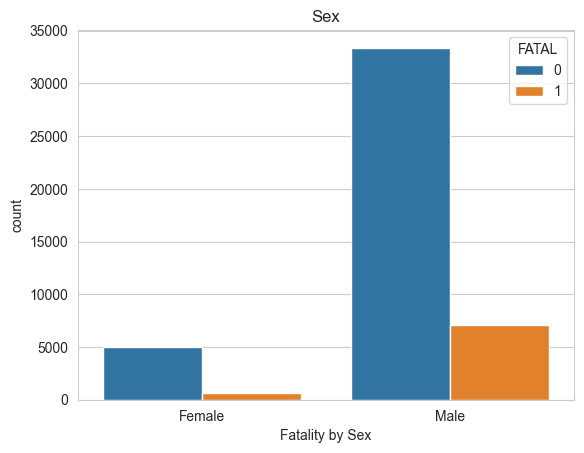

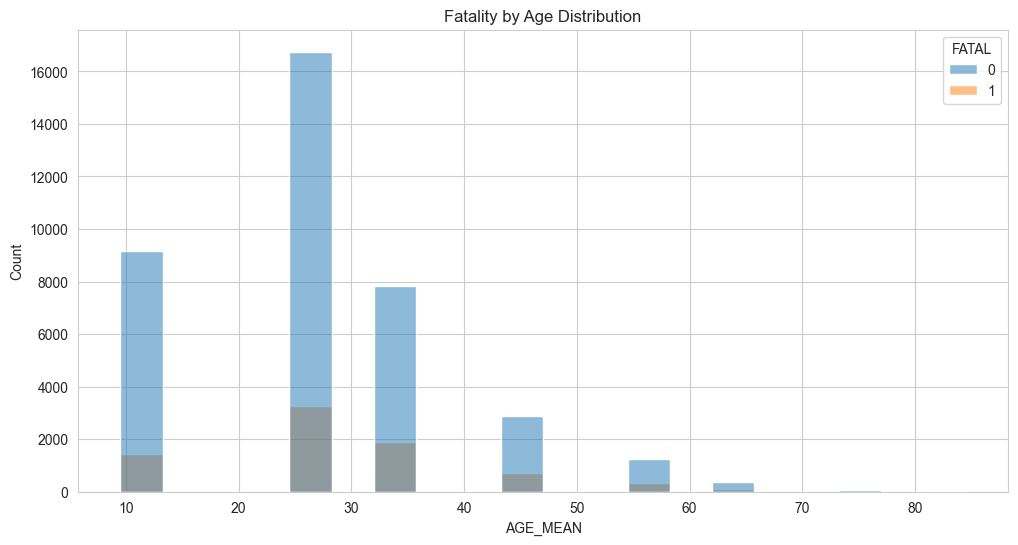

In [262]:
# sns.countplot(x=df['FATAL'])
# plt.title("Fatal vs. Non-fatal")
# plt.xticks([0, 1], ['Non-fatal', 'Fatal'])
# plt.xlabel('Fatality')
# plt.show()

sns.countplot(x=df['IS_MALE'], hue=df['FATAL'],)
plt.title("Sex")
plt.xticks([0, 1], ['Female', 'Male'])
plt.xlabel('Fatality by Sex')
plt.show()


plt.figure(figsize=(12, 6))

sns.histplot(x=df['AGE_MEAN'], hue=df['FATAL'], bins=20)
plt.title("Fatality by Age Distribution")
plt.show()


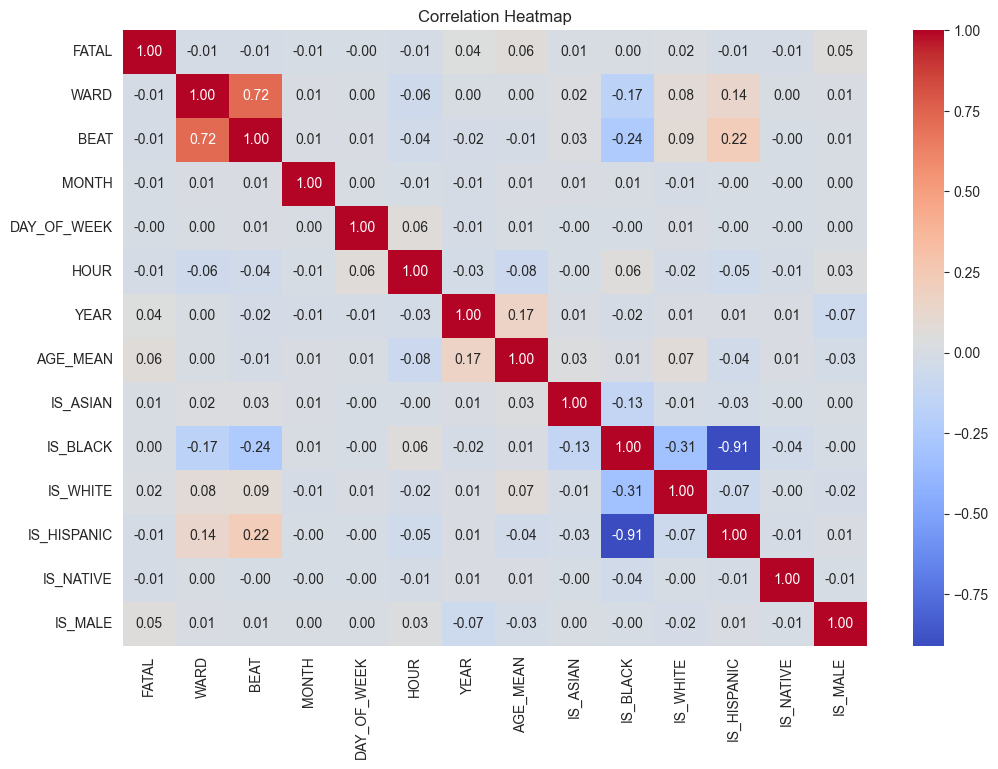

In [263]:
# df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

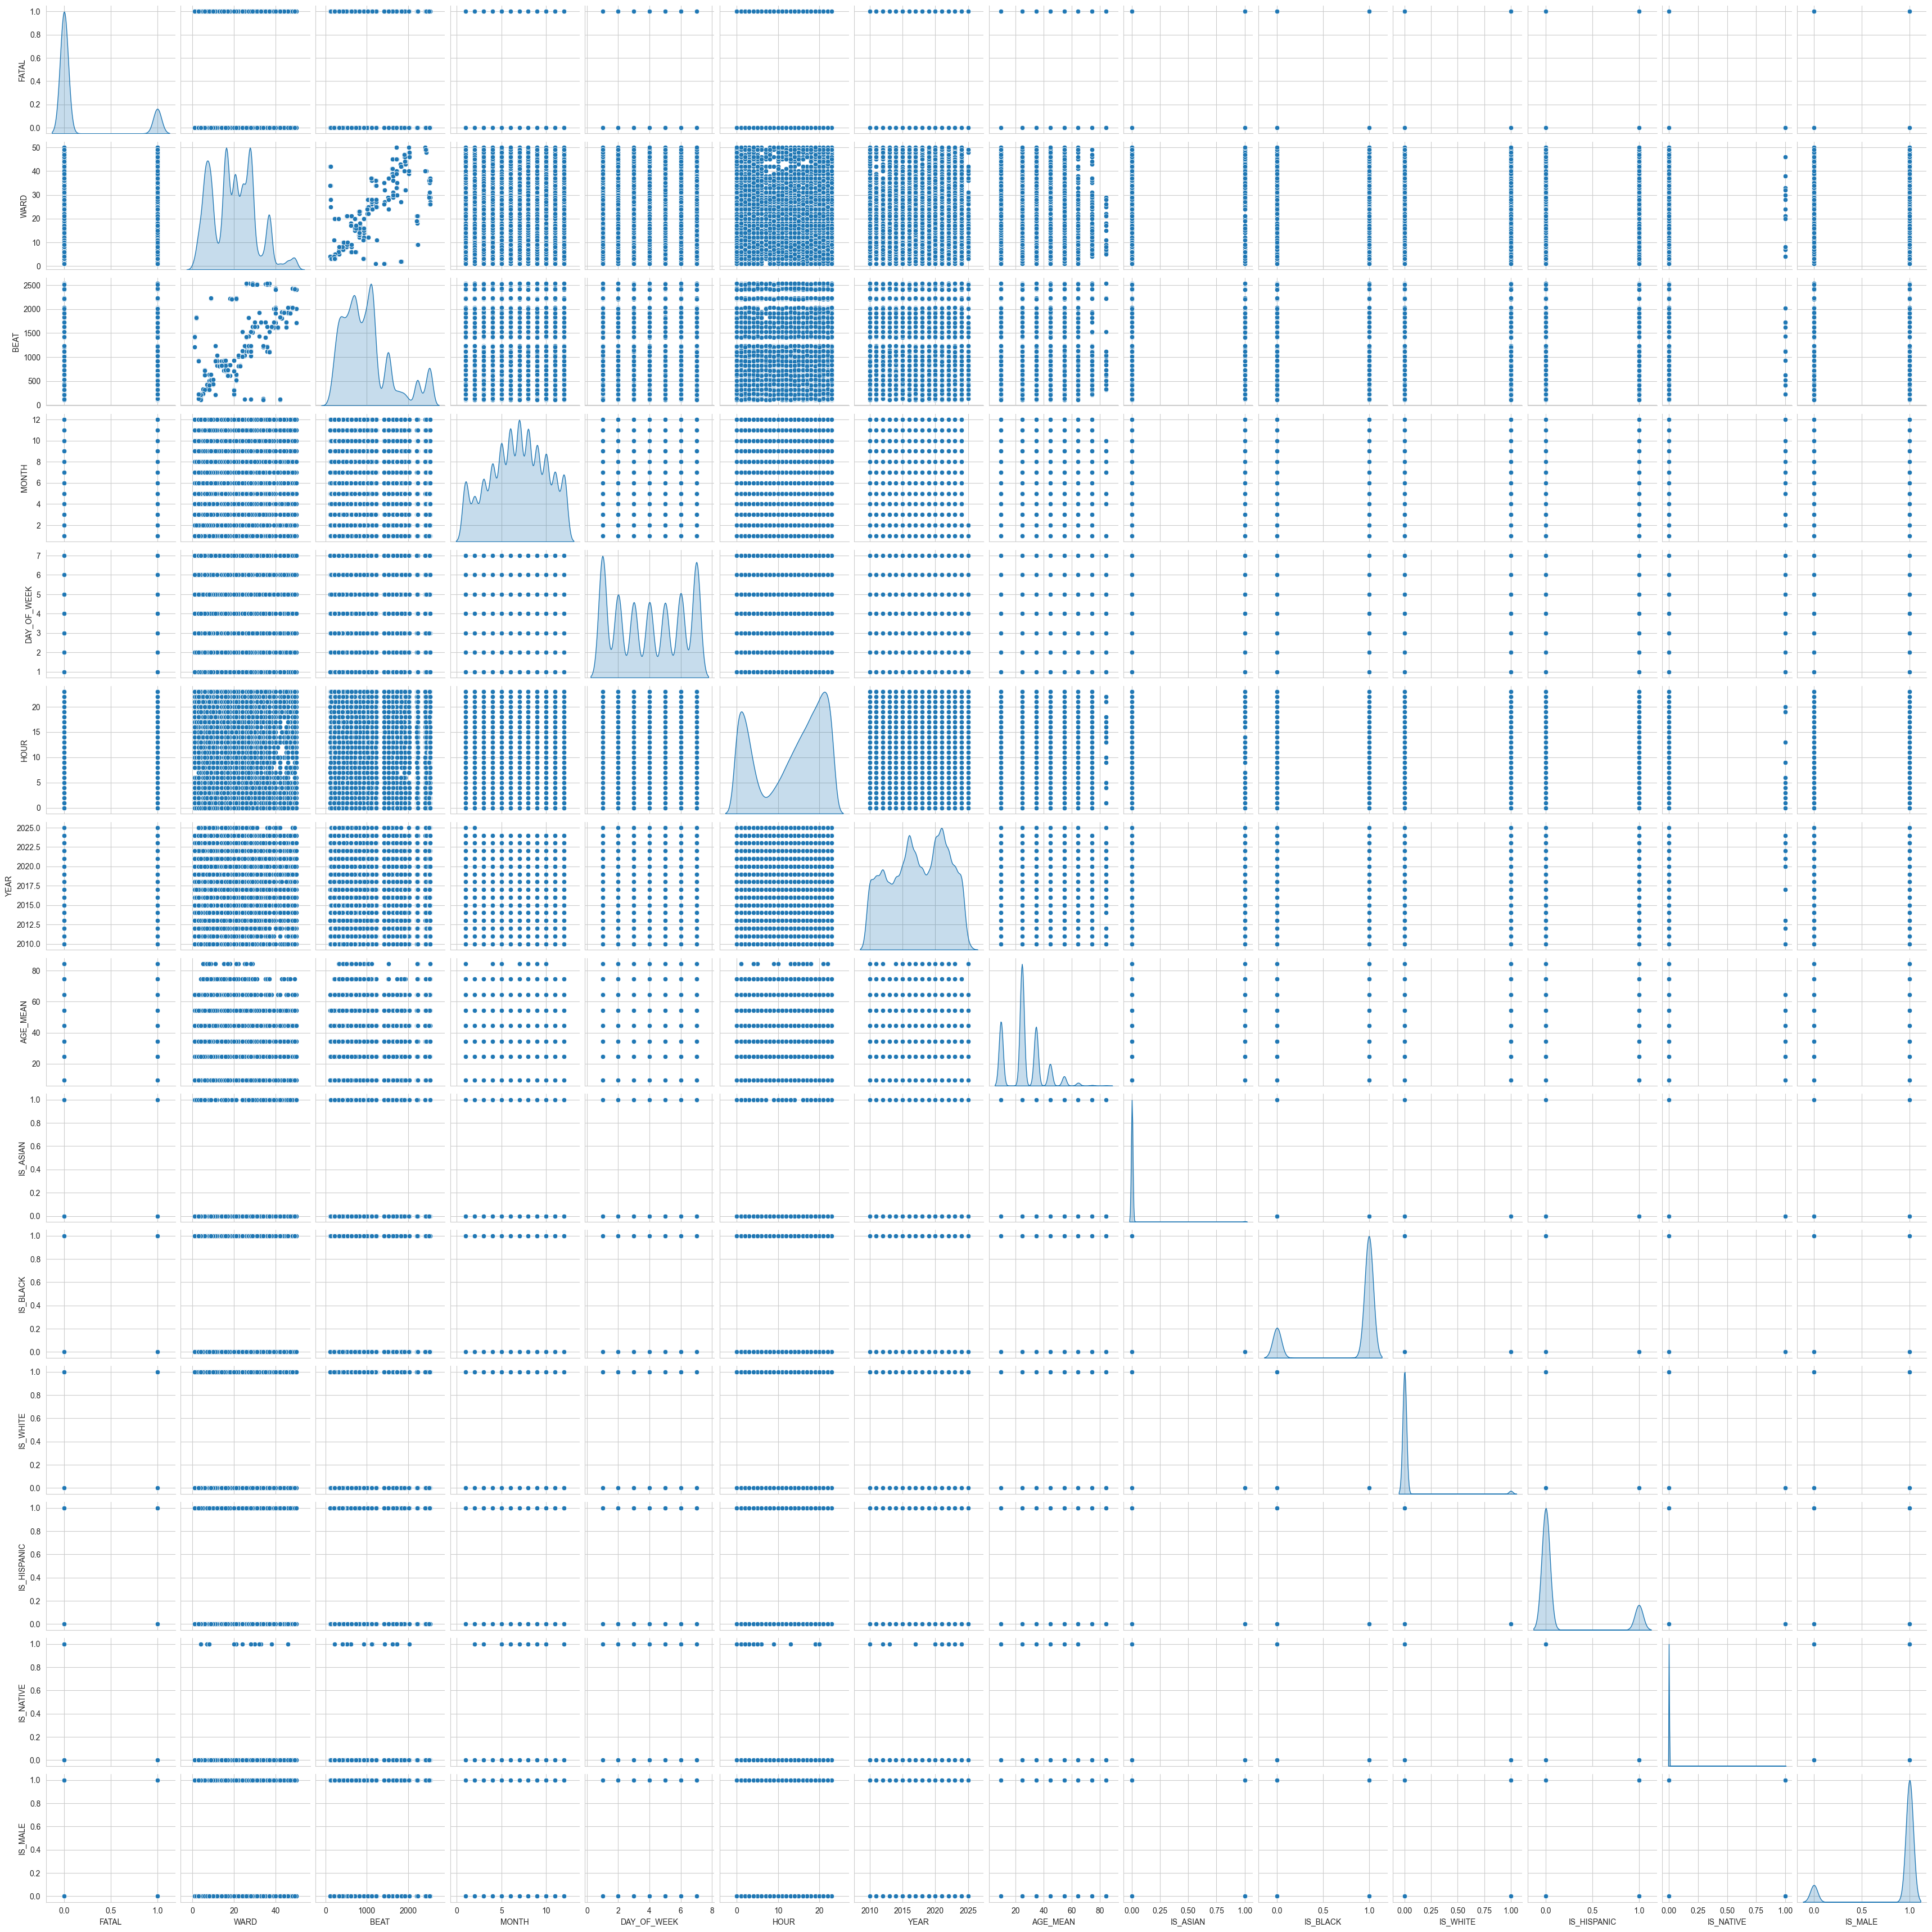

In [264]:
sns.pairplot(df, diag_kind='kde', vars=['FATAL', 'WARD', 'BEAT', 'MONTH', 'DAY_OF_WEEK', 'HOUR', 'YEAR', 'AGE_MEAN', 'IS_ASIAN', 'IS_BLACK', 'IS_WHITE', 'IS_HISPANIC', 'IS_NATIVE', 'IS_MALE'])
